# Predictions for properties prices
by [Adriana Benício](https://github.com/adrianabenicio) and [Gisliany Alves](https://github.com/gisliany)

## Goal

The main goal of this project is predict and analyze the price to buy or rent a property (like a house or an apartment) in Natal-RN. To do this, we'll use a machine learning library called sklearn and apply the K-neighboor. To get the dataset, we'll scrape multiple web pages of [VivaReal](https://www.vivareal.com.br/) with Python using BeautifulSoup and requests libraries.

In [8]:
# imports
from requests import get
from bs4 import BeautifulSoup
from math import ceil
from time import sleep
from random import randint
from time import time
from warnings import warn
from IPython.core.display import clear_output
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt
import seaborn as sns

## Getting the data using web scraping

We’ll build our multiple page script by doing three things:
- Making all the requests we want from within the loop.
- Controlling the loop’s rate to avoid bombarding the server with requests.
- Monitoring the loop while it runs.

The number of pages is calculated on the first iteration of the loop. We get the total of ads and divide by 30 (number of ads by page). Then, we apply the ceil() function over the result.

The scrapped data were the sales and rental announcements of houses and apartments. We get information like:

- <span style="background-color: #F9EBEA; color:##C0392B">business</span>: sail or rental
- <span style="background-color: #F9EBEA; color:##C0392B">property</span>: house or apartment
- <span style="background-color: #F9EBEA; color:##C0392B">neighborhood</span>: property's neighborhood
- <span style="background-color: #F9EBEA; color:##C0392B">bedroom</span>: number of bedrooms
- <span style="background-color: #F9EBEA; color:##C0392B">bathroom</span>: number of bathrooms
- <span style="background-color: #F9EBEA; color:##C0392B">suite</span>: number of suites
- <span style="background-color: #F9EBEA; color:##C0392B">garage</span>: number of garages
- <span style="background-color: #F9EBEA; color:##C0392B">price</span>: monthly price for the rental or total price for the sale
- <span style="background-color: #F9EBEA; color:##C0392B">area</span>: the property's area
- <span style="background-color: #F9EBEA; color:##C0392B">condominium</span>: condominium price

Each of the collected data received a treatment related to their typing and some special characters were removed.

In [2]:
# infos to do scrap
properties = ['casa_residencial','apartamento_residencial']
business = ['venda', 'aluguel']
place = '/rio-grande-do-norte/natal/'
total_pages = 100

# infos to save
df_business = []
df_property = []
df_neighborhood = []
df_bedroom = []
df_suite = []
df_bathroom = []
df_garage = []
df_condominium = []
df_area = []
df_price = []

# specify the url
url = 'https://www.vivareal.com.br/'
start_time = time()
requests = 0
writeHeader = True

for b in business:
    for prop in properties:
        page = 1
        have_pages = True
        while(have_pages):
            # Final URL
            final_url = url + b + place + prop + '?pagina=' + str(page)
            response = get(final_url)
            
            html = BeautifulSoup(response.text, 'html.parser')
            
            # Calculates the total of pages
            if page == 1:
                total_records = int(html.select("span.js-totalRecords")[0].text.replace('.', ''))
                total_pages = ceil(total_records/30)
                
            if page == total_pages:
                have_pages = False
            else:
                page += 1
                
            sleep(randint(1, 2))
    
            # Monitor the requests
            requests += 1
            elapsed_time = time() - start_time
            print('Request:{}; Frequency: {} requests/s'.format(requests, requests/elapsed_time))
            clear_output(wait = True)

            # Treatment
            list_ads = html.find('div', id = 'js-results-list').select('> div')

            for div in list_ads:
                df_business.append(b)
                df_property.append(prop)
                df_neighborhood.append(div.select("span[class*='address'] span")[0].text[:-12].split('- ')[-1])
                df_bedroom.append(int(div.select("li[class*='rooms'] span[class*='value']")[0].text.strip().split('-')[0]))
                df_bathroom.append(int(div.select("li[class*='bathroom'] span[class*='value']")[0].text.strip().split('-')[0]))
                df_garage.append(int(div.select("li[class*='garages'] span[class*='value']")[0].text.strip().split('-')[0]))
                
                area = div.select("li[class*='area'] span[class*='value']")[0].text.strip().split('-')[0]
                if area.isdigit():
                    df_area.append(float(area))
                else:
                    df_area.append('')
                    
                
                st = div.select("li[class*='suites'] span[class*='value']")
                if len(st) > 0:
                    df_suite.append(int(st[0].text.strip().split('-')[0]))
                else:
                    df_suite.append(0)

                condo = div.select("strong[class*='condo-price']")
                
                if len(condo) == 0:
                    df_condominium.append(0)
                elif 'R$' in condo[0].text:
                    df_condominium.append(float(condo[0].text.strip().split(' ')[-1].replace('.', '')))
                else:
                    df_condominium.append(condo[0].text.strip())
                    

                pri = div.select("div[class*='prices']")[0].text.strip()
                if 'Diário' in pri:
                    df_price.append(float(pri.replace('/ Diário', '').split()[-1]) * 30)
                elif 'Anual' in pri:
                    df_price.append(float(pri.replace('/ Anual', '').split()[-1]))
                elif 'Semanal' in pri:
                    df_price.append(float(pri.replace('/ Semanal', '').split()[-1]) * 4)
                else:
                    df_price.append(float(pri.split(' ')[-1].replace('.', '')))

                # Writting into a csv file
                data_to_write = {
                    'business': b,
                    'property': prop.replace('_residencial', ''),
                    'neighborhood': df_neighborhood[-1],
                    'area': df_area[-1],
                    'bedroom': df_bedroom[-1],
                    'bathroom': df_bathroom[-1],
                    'garage': df_garage[-1],
                    'suite': df_suite[-1],
                    'condominium': df_condominium[-1],
                    'price': df_price[-1]
                }
                pd.DataFrame(data=data_to_write, index=[0]).to_csv('vivareal.csv', mode='a', header=writeHeader) # writes into a file
                writeHeader = False

Request:410; Frequency: 0.22657941772276405 requests/s


## Analysing the data

After the acquisition, the data was read from the csv file and the content was analysed. First, the 'não informado' value at condominium column was replaced by zero, so that it could be converted into float. Besides that, ranges were established for 
area, bedroom, bathroom, suite and garage values to remove discrepant values informed by advertisers in the vivareal website. And then, for better predictions, all data were grouped by property and business, resulting in 4 different data sets (house-rent, house-sale, apartment-rent and apartment-sale) which will used to train and test 4 different models.

In [9]:
data = pd.read_csv('vivareal.csv', encoding='latin-1')
data['condominium'] = data['condominium'].str.replace('não informado', '0').astype('float')
data.dropna(axis=0, how='any', subset=['area'], inplace=True)

data = data[data['area'].apply(lambda a: a > 0 and a < 2500)]
data = data[data['bedroom'].apply(lambda a: a > 0 and a < 20)]
data = data[data['bathroom'].apply(lambda a: a > 0 and a < 20)]
data = data[data['suite'].apply(lambda a: a > 0 and a < 20)]
data = data[data['garage'].apply(lambda a: a < 30)]

data_aluguel = data[data['business'] == 'aluguel']
data_venda = data[data['business'] == 'venda']
data_aluguel_casa = data_aluguel[data_aluguel['property'] == 'casa']
data_aluguel_apto = data_aluguel[data_aluguel['property'] == 'apartamento']
data_venda_casa = data_venda[data_venda['property'] == 'casa']
data_venda_apto = data_venda[data_venda['property'] == 'apartamento']

print(len(data_aluguel_casa))
print(len(data_aluguel_apto))
print(len(data_venda_casa))
print(len(data_venda_apto))

386
1299
1614
5961


A graph for each data set was generated to visually verify the distribution of the data.

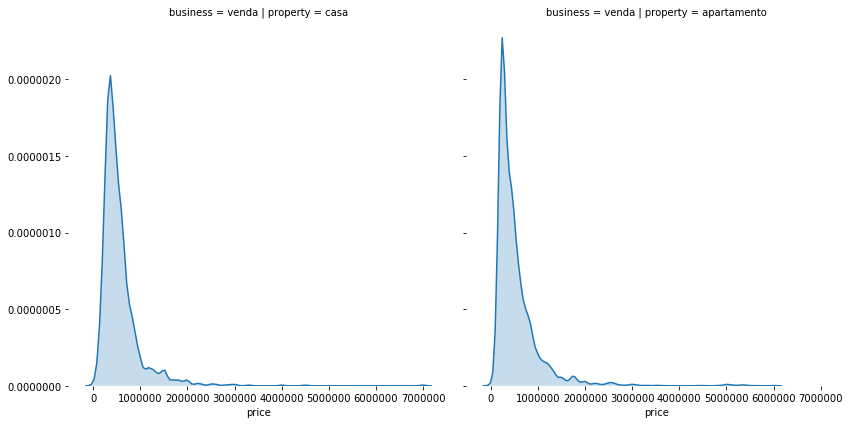

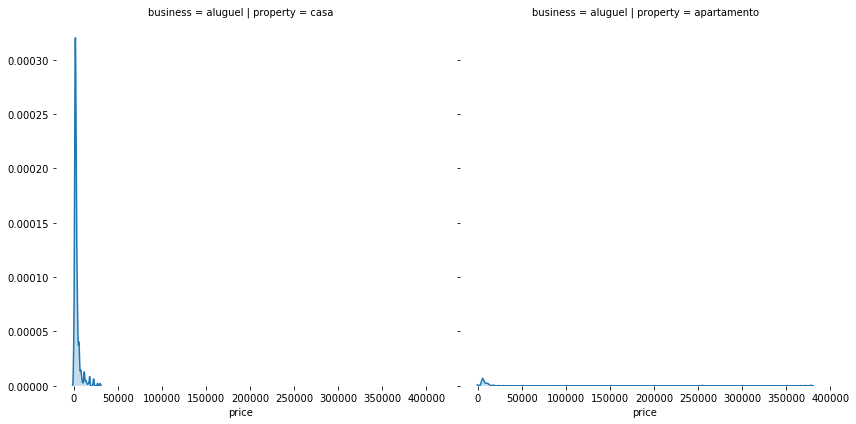

In [11]:
g = sns.FacetGrid(data_venda, col="property", row="business", size=6)
g.map(sns.kdeplot, "price", shade=True)
sns.despine(left=True, bottom=True)

g2 = sns.FacetGrid(data_aluguel, col="property", row="business", size=6)
g2.map(sns.kdeplot, "price", shade=True)
sns.despine(left=True, bottom=True)

plt.show()

As we want to use data to train models, more data will provide more accuracies in predictions. We saw in practice that, in general, few training data cause poor performance of the model, that is high error values. So, we selected only the ranges of prices with the most number of properties in each data set.

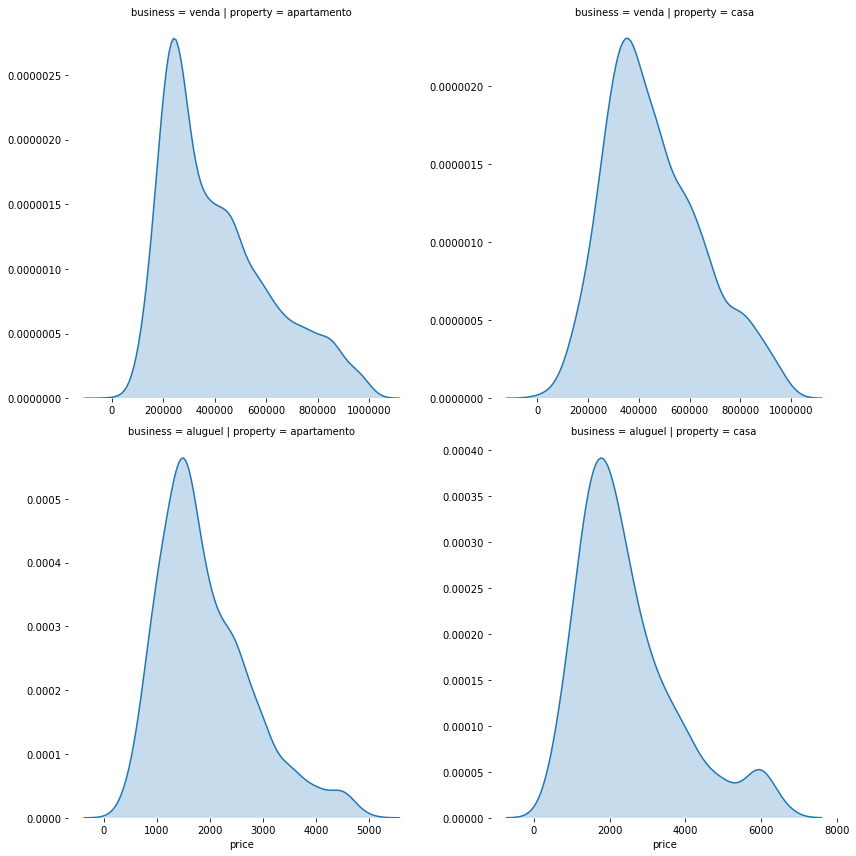

In [31]:
data_venda_casa = data_venda_casa[data_venda_casa['price'].apply(lambda x: x > 10000 and x < 1000000)]
data_venda_apto = data_venda_apto[data_venda_apto['price'].apply(lambda x: x > 10000 and x < 1000000)]
data_aluguel_casa = data_aluguel_casa[data_aluguel_casa['price'].apply(lambda x: x > 250 and x < 7000)]
data_aluguel_apto = data_aluguel_apto[data_aluguel_apto['price'].apply(lambda x: x > 250 and x < 5000)]

frames = [data_venda_apto, data_venda_casa, data_aluguel_casa, data_aluguel_apto]
g1 = sns.FacetGrid(pd.concat(frames), col="property", row="business", size=6, sharey=False, sharex=False)
g1.map(sns.kdeplot, "price", shade=True)
sns.despine(left=True, bottom=True)

plt.show()

And then, we normalized the data before use them for creating the regression models using the k-nearest neighbors algorithm.

In [33]:
#Normalizing
n_data_aluguel_casa = data_aluguel_casa[['area','bathroom','bedroom','condominium','garage','suite','price']]
n_data_aluguel_casa = (n_data_aluguel_casa - n_data_aluguel_casa.mean()) / (n_data_aluguel_casa.std())
n_data_aluguel_casa['price'] = data_aluguel_casa['price']
n_data_aluguel_casa['business'] = data_aluguel_casa['business']
n_data_aluguel_casa['neighborhood'] = data_aluguel_casa['neighborhood']
n_data_aluguel_casa['property'] = data_aluguel_casa['property']

n_data_aluguel_apto = data_aluguel_apto[['area','bathroom','bedroom','condominium','garage','suite','price']]
n_data_aluguel_apto = (n_data_aluguel_apto - n_data_aluguel_apto.mean()) / (n_data_aluguel_apto.std())
n_data_aluguel_apto['price'] = data_aluguel_apto['price']
n_data_aluguel_apto['business'] = data_aluguel_apto['business']
n_data_aluguel_apto['neighborhood'] = data_aluguel_apto['neighborhood']
n_data_aluguel_apto['property'] = data_aluguel_apto['property']

n_data_venda_casa = data_venda_casa[['area','bathroom','bedroom','condominium','garage','suite','price']]
n_data_venda_casa = (n_data_venda_casa - n_data_venda_casa.mean()) / (n_data_venda_casa.std())
n_data_venda_casa['price'] = data_venda_casa['price']
n_data_venda_casa['business'] = data_venda_casa['business']
n_data_venda_casa['neighborhood'] = data_venda_casa['neighborhood']
n_data_venda_casa['property'] = data_venda_casa['property']

n_data_venda_apto = data_venda_apto[['area','bathroom','bedroom','condominium','garage','suite','price']]
n_data_venda_apto = (n_data_venda_apto - n_data_venda_apto.mean()) / (n_data_venda_apto.std())
n_data_venda_apto['price'] = data_venda_apto['price']
n_data_venda_apto['business'] = data_venda_apto['business']
n_data_venda_apto['neighborhood'] = data_venda_apto['neighborhood']
n_data_venda_apto['property'] = data_venda_apto['property']

print(len(n_data_venda_apto))
print(len(n_data_venda_casa))
print(len(n_data_aluguel_apto))
print(len(n_data_aluguel_casa))

5360
1466
1234
341


## Choosing the Features and the Hyperparameter for the Regression Models

The data contained in each data set were shuffled and, after, splitted into two parts with 80 and 20% of all data, for training and testing respectively.

In [34]:
import numpy as np
np.random.seed(1)

#Defining the training and testing datasets
df1 = n_data_venda_apto
df1 = df1.iloc[np.random.permutation(len(df1))]

df2 = n_data_venda_casa
df2 = df2.iloc[np.random.permutation(len(df2))]

df3 = n_data_aluguel_apto
df3 = df3.iloc[np.random.permutation(len(df3))]

df4 = n_data_aluguel_casa
df4 = df4.iloc[np.random.permutation(len(df4))]

n = int(0.8*len(df1))
train_df1 = df1.iloc[:n]
test_df1 = df1.iloc[n:]

n = int(0.8*len(df2))
train_df2 = df2.iloc[:n]
test_df2 = df2.iloc[n:]

n = int(0.8*len(df3))
train_df3 = df3.iloc[:n]
test_df3 = df3.iloc[n:]

n = int(0.8*len(df4))
train_df4 = df4.iloc[:n]
test_df4 = df4.iloc[n:]

The code bellow finds the best number of nearby neighbors (k parameter) for different set of features and group of training data. The best k and set of features are the ones that provide together the smallest mean squared error (RMSE).

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

#Checking the best k for each set of features

###### apartment sale ########
print('data_venda_apto')
features = ['area','bathroom','bedroom','condominium','garage','suite']
while (len(features) > 0):
    mse_values = list()
    hyper_params = [x for x in range(1,31)]

    for k in hyper_params:
        knn = KNeighborsRegressor(n_neighbors=k, algorithm='brute')
        knn.fit(train_df1[features], train_df1['price'])
        predictions = knn.predict(test_df1[features])
        mse_values.append(mean_squared_error(test_df1['price'], predictions))

    print(features, 'k='+str(mse_values.index(min(mse_values))+1), 'RMSE='+str(np.sqrt(min(mse_values))))
    features.pop()

###### house sale ########
print('data_venda_casa') 
features = ['area','bathroom','bedroom','condominium','garage','suite']
while (len(features) > 0):
    mse_values = list()
    hyper_params = [x for x in range(1,31)]

    for k in hyper_params:
        knn = KNeighborsRegressor(n_neighbors=k, algorithm='brute')
        knn.fit(train_df2[features], train_df2['price'])
        predictions = knn.predict(test_df2[features])
        mse_values.append(mean_squared_error(test_df2['price'], predictions))

    print(features, 'k='+str(mse_values.index(min(mse_values))+1), 'RMSE='+str(np.sqrt(min(mse_values))))
    features.pop()
    
###### apartment rent ########
print('data_aluguel_apto')
features = ['area','bathroom','bedroom','condominium','garage','suite']
while (len(features) > 0):
    mse_values = list()
    hyper_params = [x for x in range(1,31)]

    for k in hyper_params:
        knn = KNeighborsRegressor(n_neighbors=k, algorithm='brute')
        knn.fit(train_df3[features], train_df3['price'])
        predictions = knn.predict(test_df3[features])
        mse_values.append(mean_squared_error(test_df3['price'], predictions))

    print(features, 'k='+str(mse_values.index(min(mse_values))+1), 'RMSE='+str(np.sqrt(min(mse_values))))
    features.pop()

###### house rent ########
print('data_aluguel_casa')
features = ['area','bathroom','bedroom','condominium','garage','suite']
while (len(features) > 0):
    mse_values = list()
    hyper_params = [x for x in range(1,31)]

    for k in hyper_params:
        knn = KNeighborsRegressor(n_neighbors=k, algorithm='brute')
        knn.fit(train_df4[features], train_df4['price'])
        predictions = knn.predict(test_df4[features])
        mse_values.append(mean_squared_error(test_df4['price'], predictions))

    print(features, 'k='+str(mse_values.index(min(mse_values))+1), 'RMSE='+str(np.sqrt(min(mse_values))))
    features.pop()

data_venda_apto
['area', 'bathroom', 'bedroom', 'condominium', 'garage', 'suite'] k=7 RMSE=104885.57631
['area', 'bathroom', 'bedroom', 'condominium', 'garage'] k=10 RMSE=108754.093647
['area', 'bathroom', 'bedroom', 'condominium'] k=8 RMSE=111494.637302
['area', 'bathroom', 'bedroom'] k=15 RMSE=110859.364675
['area', 'bathroom'] k=21 RMSE=113852.920981
['area'] k=23 RMSE=118217.857245
data_venda_casa
['area', 'bathroom', 'bedroom', 'condominium', 'garage', 'suite'] k=27 RMSE=142632.098438
['area', 'bathroom', 'bedroom', 'condominium', 'garage'] k=17 RMSE=145532.046571
['area', 'bathroom', 'bedroom', 'condominium'] k=27 RMSE=148936.962003
['area', 'bathroom', 'bedroom'] k=29 RMSE=147796.585134
['area', 'bathroom'] k=17 RMSE=149387.483718
['area'] k=30 RMSE=163667.827888
data_aluguel_apto
['area', 'bathroom', 'bedroom', 'condominium', 'garage', 'suite'] k=15 RMSE=689.539116263
['area', 'bathroom', 'bedroom', 'condominium', 'garage'] k=6 RMSE=683.756432986
['area', 'bathroom', 'bedroom',

Bellow are generated graphic representations of the hyper parameters k and respective mean squared error, obtained for each best set of features, which can help to check the k value selected for each regression model.

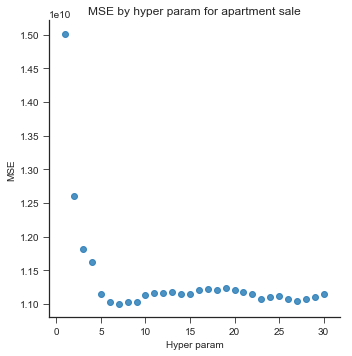

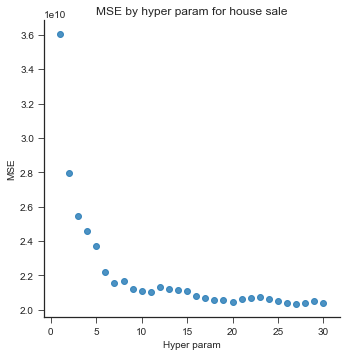

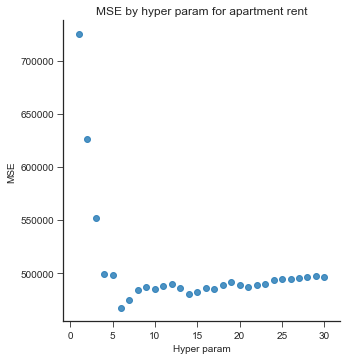

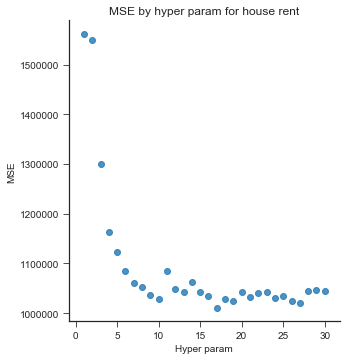

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ['area','bathroom','bedroom','condominium','garage','suite']
mse_values = list()
hyper_params = [x for x in range(1,31)]
for k in hyper_params:
    knn = KNeighborsRegressor(n_neighbors=k, algorithm='brute')
    knn.fit(train_df1[features], train_df1['price'])
    predictions = knn.predict(test_df1[features])
    mse_values.append(mean_squared_error(test_df1['price'], predictions))

df = pd.DataFrame()
df["x"] = range(1,31)
df["y"] = mse_values
sns.set_style("ticks")
sns.lmplot('x','y',data=df,fit_reg=False)
plt.title('MSE by hyper param for apartment sale')
plt.xlabel('Hyper param')
plt.ylabel('MSE')
    

features = ['area','bathroom','bedroom','condominium','garage','suite']
mse_values = list()
hyper_params = [x for x in range(1,31)]

for k in hyper_params:
    knn = KNeighborsRegressor(n_neighbors=k, algorithm='brute')
    knn.fit(train_df2[features], train_df2['price'])
    predictions = knn.predict(test_df2[features])
    mse_values.append(mean_squared_error(test_df2['price'], predictions))
    
df = pd.DataFrame()
df["x"] = range(1,31)
df["y"] = mse_values
sns.set_style("ticks")
sns.lmplot('x','y',data=df,fit_reg=False)
plt.title('MSE by hyper param for house sale')
plt.xlabel('Hyper param')
plt.ylabel('MSE')
   

features = ['area','bathroom','bedroom','condominium','garage']
mse_values = list()
hyper_params = [x for x in range(1,31)]

for k in hyper_params:
    knn = KNeighborsRegressor(n_neighbors=k, algorithm='brute')
    knn.fit(train_df3[features], train_df3['price'])
    predictions = knn.predict(test_df3[features])
    mse_values.append(mean_squared_error(test_df3['price'], predictions))

df = pd.DataFrame()
df["x"] = range(1,31)
df["y"] = mse_values
sns.set_style("ticks")
sns.lmplot('x','y',data=df,fit_reg=False)
plt.title('MSE by hyper param for apartment rent')
plt.xlabel('Hyper param')
plt.ylabel('MSE') 


features = ['area','bathroom','bedroom','condominium','garage']
mse_values = list()
hyper_params = [x for x in range(1,31)]

for k in hyper_params:
    knn = KNeighborsRegressor(n_neighbors=k, algorithm='brute')
    knn.fit(train_df4[features], train_df4['price'])
    predictions = knn.predict(test_df4[features])
    mse_values.append(mean_squared_error(test_df4['price'], predictions))
    
df = pd.DataFrame()
df["x"] = range(1,31)
df["y"] = mse_values
sns.set_style("ticks")
sns.lmplot('x','y',data=df,fit_reg=False)
plt.title('MSE by hyper param for house rent')
plt.xlabel('Hyper param')
plt.ylabel('MSE')
plt.show()

## Performing K-Fold Cross Validation

The K-fold cross validation was applied for each model defined in the last sessions. The lowest average RMSE will be use to determine the margin of error of the predictions. 

In [127]:
num_folds = [3, 5, 7, 9, 10, 11, 13, 15, 17, 19, 21, 23]

print('data_venda_apto')
for fold in num_folds:
    kf = KFold(fold, shuffle=True, random_state=1)
    model = KNeighborsRegressor(n_neighbors=7)
    mses = cross_val_score(model, df1[['area', 'bathroom', 'bedroom', 'condominium', 'garage', 'suite']],
                           df1["price"], scoring="neg_mean_squared_error", cv=kf)
    rmses = np.sqrt(np.absolute(mses))
    avg_rmse = np.mean(rmses)
    std_rmse = np.std(rmses)
    print(str(fold), "folds: ", "avg RMSE: ", str(avg_rmse), "std RMSE: ", str(std_rmse))


print('data_venda_casa')
for fold in num_folds:
    kf = KFold(fold, shuffle=True, random_state=1)
    model = KNeighborsRegressor(n_neighbors=27)
    mses = cross_val_score(model, df2[['area', 'bathroom', 'bedroom', 'condominium', 'garage', 'suite']],
                           df2["price"], scoring="neg_mean_squared_error", cv=kf)
    rmses = np.sqrt(np.absolute(mses))
    avg_rmse = np.mean(rmses)
    std_rmse = np.std(rmses)
    print(str(fold), "folds: ", "avg RMSE: ", str(avg_rmse), "std RMSE: ", str(std_rmse))
    

print('data_aluguel_apto')
for fold in num_folds:
    kf = KFold(fold, shuffle=True, random_state=1)
    model = KNeighborsRegressor(n_neighbors=6)
    mses = cross_val_score(model, df3[['area', 'bathroom', 'bedroom', 'condominium', 'garage']],
                           df3["price"], scoring="neg_mean_squared_error", cv=kf)
    rmses = np.sqrt(np.absolute(mses))
    avg_rmse = np.mean(rmses)
    std_rmse = np.std(rmses)
    print(str(fold), "folds: ", "avg RMSE: ", str(avg_rmse), "std RMSE: ", str(std_rmse))
    

print('data_aluguel_casa')
for fold in num_folds:
    kf = KFold(fold, shuffle=True, random_state=1)
    model = KNeighborsRegressor(n_neighbors=17)
    mses = cross_val_score(model, df4[['area', 'bathroom', 'bedroom', 'condominium', 'garage']],
                           df4["price"], scoring="neg_mean_squared_error", cv=kf)
    rmses = np.sqrt(np.absolute(mses))
    avg_rmse = np.mean(rmses)
    std_rmse = np.std(rmses)
    print(str(fold), "folds: ", "avg RMSE: ", str(avg_rmse), "std RMSE: ", str(std_rmse))

data_venda_apto
3 folds:  avg RMSE:  103967.517418 std RMSE:  1147.59596978
5 folds:  avg RMSE:  103484.519959 std RMSE:  3445.51934241
7 folds:  avg RMSE:  103250.153349 std RMSE:  4718.35518613
9 folds:  avg RMSE:  102570.506612 std RMSE:  4144.18576539
10 folds:  avg RMSE:  102596.321133 std RMSE:  4787.84302022
11 folds:  avg RMSE:  102330.750128 std RMSE:  5236.03134448
13 folds:  avg RMSE:  102080.524234 std RMSE:  5180.53575325
15 folds:  avg RMSE:  102273.446238 std RMSE:  4740.86767356
17 folds:  avg RMSE:  101950.774097 std RMSE:  6703.57962917
19 folds:  avg RMSE:  101987.582043 std RMSE:  6295.79995264
21 folds:  avg RMSE:  101976.309379 std RMSE:  8026.53859888
23 folds:  avg RMSE:  101919.924466 std RMSE:  6787.24505148
data_venda_casa
3 folds:  avg RMSE:  146706.376832 std RMSE:  2189.81952256
5 folds:  avg RMSE:  145872.55928 std RMSE:  2705.16304817
7 folds:  avg RMSE:  146222.652416 std RMSE:  4261.5198593
9 folds:  avg RMSE:  145804.815162 std RMSE:  6826.08939658
10

## Examples of Predictions

We can use the models found in this mission to predict prices of properties from information about the quantity of bathrooms, bedrooms, garages and suites, the condominium price and area. The predictor will return the minimum and maximum prices.

In [43]:
# House rent

house_info = {
    'area' : 2000,
    'bathroom' : 4,
    'bedroom' : 5,
    'garage' : 3,
    'condominium' : 0
}

test_df4 = pd.DataFrame(data=house_info, index=[0])

features = ['area', 'bathroom', 'bedroom', 'condominium', 'garage']
knn = KNeighborsRegressor(n_neighbors=17, algorithm='brute')
knn.fit(train_df4[features], train_df4['price'])
predictions = knn.predict(test_df4[features])

print('House rent')
print(predictions - 981.699749433)
print(predictions + 981.699749433)


# Apartment sale

apart_info = {
    'area' : 100,
    'bathroom' : 2,
    'bedroom' : 3,
    'garage' : 1,
    'condominium' : 900,
    'suite' : 1
}

test_df2 = pd.DataFrame(data=apart_info, index=[0])

features = ['area', 'bathroom', 'bedroom', 'condominium', 'garage', 'suite']
knn = KNeighborsRegressor(n_neighbors=7, algorithm='brute')
knn.fit(train_df2[features], train_df2['price'])
predictions = knn.predict(test_df2[features])

print('Apartment sale')
print(predictions - 101919.924466)
print(predictions + 101919.924466)

House rent
[ 3347.71201527]
[ 5311.11151414]
Apartment sale
[ 403080.075534]
[ 606919.924466]
